In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
from sklearn.metrics import r2_score
from io import StringIO
import glob
import os
import raytracing as rt
from scipy.ndimage import gaussian_filter

import scipy.optimize as spo
import scipy.constants as spc
import scipy.integrate as spi
import scipy.linalg as spl
import scipy.signal as spsi
import scipy.stats as spst

In [83]:
def lire_csv(chemin_fichier):
    """
    Lecture d'un fichier CSV avec une première ligne à ignorer,
    et renvoie un DataFrame pandas.

    Args:
        chemin_fichier (str): Le chemin d'accès vers le fichier CSV.

    Returns:
        pandas.DataFrame: Un DataFrame pandas contenant les données du fichier CSV.
    """
    # Lire le fichier en ignorant la première ligne
    with open(chemin_fichier, 'r', encoding='utf-8') as fichier:
        lignes = fichier.readlines()[1:]  # Ignorer la première ligne
    
    # Préparer le contenu transformé
    contenu_transforme = []
    for ligne in lignes:
        partie_gauche, _, partie_droite = ligne.partition(', ')  # Séparer à la première virgule
        partie_gauche, partie_droite = partie_gauche.replace(',', '.'), partie_droite.replace(',', '.')   # Au cas où, mais devrait être inutile ici
        ligne_transformee = partie_gauche + ';' + partie_droite
        contenu_transforme.append(ligne_transformee)
    
    # Convertir le contenu transformé en un objet StringIO
    contenu_csv = StringIO(''.join(contenu_transforme))
    
    # Lire le contenu transformé en DataFrame
    df = pd.read_csv(contenu_csv, names=['Pixels', 'Value'],sep=";")
    return df

# Données partie 5

In [84]:
#p5_2d_320_025_bas = lire_csv(r"partie 5\2d_320_025_bas.csv")
#p5_2d_320_025_haut = lire_csv(r"partie 5\2d_320_025_haut.csv")
#p5_2d_320_025_milieu = lire_csv(r"partie 5\2d_320_025_milieu.csv")
#p5_3d_040_025_bas = lire_csv(r"partie 5\3d_040_025_bas.csv")
#p5_3d_040_025_haut = lire_csv(r"partie 5\3d_040_025_haut.csv")
#p5_3d_040_025_milieu = lire_csv(r"partie 5\3d_040_025_milieu.csv")
#p5_3d_160_025_bas = lire_csv(r"partie 5\3d_160_025_bas.csv")
#p5_3d_160_025_haut = lire_csv(r"partie 5\3d_160_025_haut.csv")
#p5_3d_160_025_milieu = lire_csv(r"partie 5\3d_160_025_milieu.csv")
#p5_3d_320_025_bas = lire_csv(r"partie 5\3d_320_025_bas.csv")
#p5_3d_320_025_haut = lire_csv(r"partie 5\3d_320_025_haut.csv")
#p5_3d_320_025_milieu = lire_csv(r"partie 5\3d_320_025_milieu.csv")
#p5_3d_320_025_dia050 = lire_csv(r"partie 5\3d_320_025_dia050.csv")
#p5_3d_320_025_dia100 = lire_csv(r"partie 5\3d_320_025_dia100.csv")
#p5_3d_320_025_dia150 = lire_csv(r"partie 5\3d_320_025_dia150.csv")
#p5_3d_320_050_bas = lire_csv(r"partie 5\3d_320_050_bas.csv")
#p5_3d_320_050_haut = lire_csv(r"partie 5\3d_320_050_haut.csv")
#p5_3d_320_050_milieu = lire_csv(r"partie 5\3d_320_050_milieu.csv")
#p5_3d_320_200_bas = lire_csv(r"partie 5\3d_320_200_bas.csv")
#p5_3d_320_200_haut = lire_csv(r"partie 5\3d_320_200_haut.csv")
#p5_3d_320_200_milieu = lire_csv(r"partie 5\3d_320_200_milieu.csv")

In [32]:
# -*- coding: utf-8 -*-
"""
%This script will implement the edge-response function's curve fitting
%algorithm given a csv file, plot the fitted curve, and calcualte the
%resulting point spread function and modulation transfer function

This script is based on the MATLAB script Analyze_Edge.m modified by Olivier Fillion at Université Laval in 2015.


Created on Mon Mar 20 15:35:58 2017

@author: Pascal Paradis

provided as is
"""

###############################################################################
# Libraries imports
###############################################################################
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.special import erf
from scipy.optimize import curve_fit, fsolve
import glob
import re
import os

###############################################################################
# functions
###############################################################################
def varerf(x, a, b, c, d):
    """This function returns an ERF. It is used by analyze_edge in the ERF
    fitting.
    """
    return a*erf(x*b - c) + d

def analyze_edge(file, imagevoxelsize, linelength=None):
    """This function imports the data of an edge profile from a .csv file
    created by the DeskCat software. It fits an ideal ERF on the raw data and
    then, computes the PSF and MTF. It plots all those 3 functions and saves
    them in png files whose names are derived from the original data file.

    Inputs:
        file =              file name
        imagevoxelsize =    voxelsize as set up in the parameters of the
                            reconstruction
        linelength =        the length of the line in the projection viewer if
                            the profile is taken on a 2D image

    Outputs:
        All the outputs are comprised of the x and y axis data

        orig =      Original profile data
        erf_fit =   ERF fitted on the original profile data
        psf =       PSF based on the ERF fit
        mtf =       MTF based on the PSF
    """
    #importing data and making sure that the decimal separators are "." instead of ","
    # the next 6 lines is the equivalent of ImprtData
    with open(file) as f:
        text = f.read()
    text = text.replace(",", ".")
    with open(file, "w") as f:
        f.write(text)
    data = np.genfromtxt(file, delimiter=". ", skip_header=1)
    pos = data[:,0]
    erf = data[:,1]
    # transforming the pixel number in a spatial position based on the
    # imagevoxelsize or the linelength if a linelength is provided
    if linelength:
        pos *= linelength/pos[-1]
        voxelsize = pos[1] - pos[0]
    else:
        pos *= imagevoxelsize
        voxelsize = pos[1] - pos[0]
    # normalizing the data
    erf /= np.max(erf)
    # reverting the erf vector so it goes up along the position
    if erf[int(len(erf)/4)] > erf[int(3*len(erf)/4)]:
        erf = np.flipud(erf)
    # eliminates the artefact that is present when the profile is drawn
    # outside of the phantom
    if erf[0] > 0.5:
        erf = erf[np.where(erf < 0.5)[0][0]:-1]
        pos = pos[np.where(erf < 0.5)[0]:-1]
    # arbitraty clipping of the profile at the beginning and at the end so
    # the ERF is centered on the x axis
    newend = int(np.where(erf > 0.6)[0][0] + 2*len(erf)/5)
    newstart = int(np.where(erf < 0.4)[0][-1] - 2*len(erf)/5)
    newerf = erf[newstart:newend]
    newpos = pos[newstart:newend]
    # Fitting the ideal ERF on the raw data
    popt, pcov = curve_fit(varerf, newpos, newerf,
                           [0.5,1,newpos[int(len(newpos)/2)],0.5])
    erf_fit = varerf(newpos, popt[0], popt[1], popt[2], popt[3])
    # Creating a spline on the ERF fit in order to get a numerical derivative
    # on the same x axis as the ERF
    erf_us = UnivariateSpline(newpos, erf_fit, k=4, s=0)
    psf = erf_us.derivative(1)(newpos)
    # Normalizing the PSF
    psf /= np.max(psf)
    # Computing the MTF from the PSF
    mtf = np.abs(np.fft.fftshift(np.fft.fft(psf)))
    mtf /= np.max(mtf)
    freq = np.fft.fftshift(np.fft.fftfreq(len(psf), d=voxelsize))

    # Outputting the plots
    fname = os.path.basename(file)
    # ERF plot
    plt.figure(file + " erf")
    plt.plot(pos, erf, label="mesurée", lw=1.5, color="blue")
    plt.plot(newpos, erf_fit, label="ajustée", lw=2, color="red", ls="--")
    plt.legend(loc="best", fontsize=20)
    plt.xlabel("Position $x$ [mm]", fontsize=24)
    plt.ylabel("ERF", fontsize=24)
    plt.tick_params(labelsize=20)
    plt.margins(0.05)
    plt.tight_layout()
    plt.savefig("erf_" + fname[:-4] + ".png", dpi=200)

    # PSF plot
    plt.figure(file + " psf")
    plt.plot(newpos, psf)
    plt.xlabel("Position $x$ [mm]", fontsize=24)
    plt.ylabel("PSF", fontsize=24)
    plt.tick_params(labelsize=20)
    plt.margins(0.05)
    plt.tight_layout()
    plt.savefig(fname[:-4] + "_psf.png", dpi=200)

    # MTF plot
    plt.figure(file + " mtf")
    plt.plot(freq, mtf)
    plt.xlim(0, 1.2)
    plt.xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=24)
    plt.ylabel("MTF", fontsize=24)
    plt.tick_params(labelsize=20)
    plt.tight_layout()
    plt.savefig(fname[:-4] + "_mtf.png", dpi=200)

    # returning the orig, erf_fit, psf, mtf
    #return (newpos, newerf), (newpos, erf_fit), (newpos, psf), (freq, mtf)
    return (freq, mtf)


(array([-20.        , -19.96497373, -19.92994746, ...,  19.89492119,
         19.92994746,  19.96497373]),
 array([1.96895657e-15, 1.92337677e-15, 2.00227601e-15, ...,
        1.78058958e-15, 2.01159199e-15, 1.91013411e-15]))

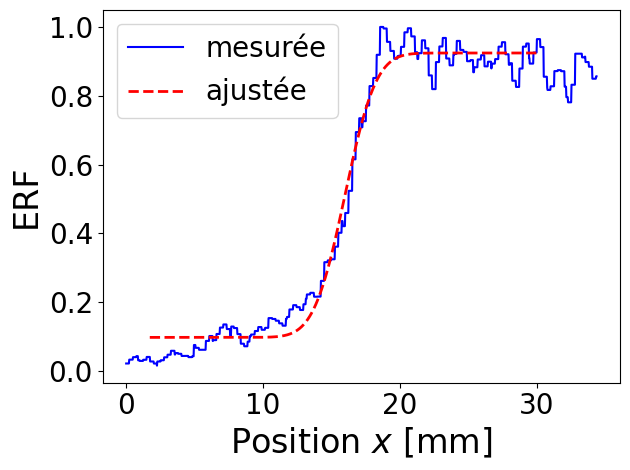

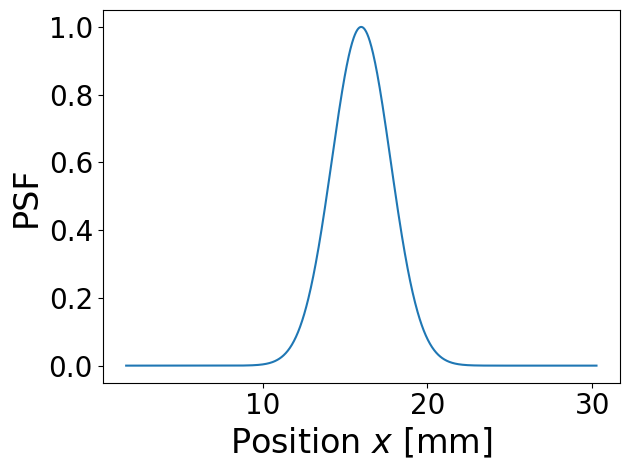

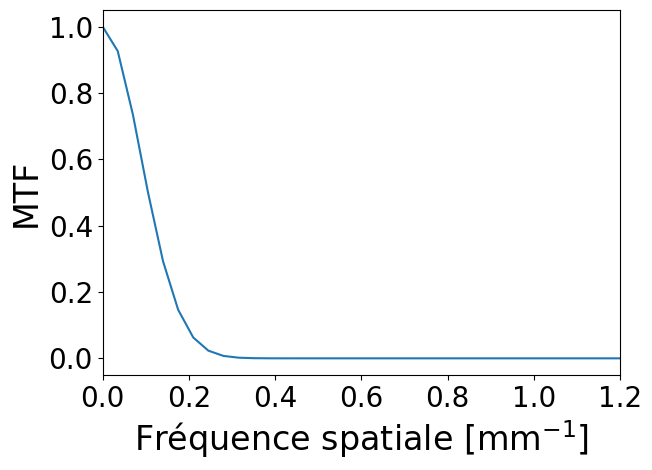

In [33]:
analyze_edge('partie 5/3d_320_025_milieu.csv', 0.25)

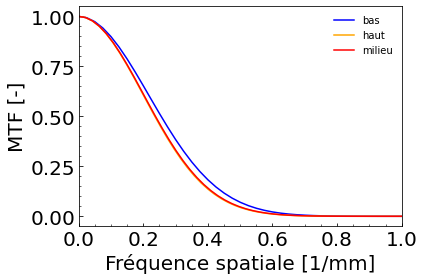

In [86]:
(freq_bas, mtf_bas) = analyze_edge('partie 5/2d_320_025_bas.csv', 0.25)
(freq_haut, mtf_haut) = analyze_edge('partie 5/2d_320_025_haut.csv', 0.25)
(freq_milieu, mtf_milieu) = analyze_edge('partie 5/2d_320_025_milieu.csv', 0.25)

plt.figure()
plt.plot(freq_bas, mtf_bas, color="blue",label='bas')
plt.plot(freq_haut, mtf_haut, color="orange", label='haut')
plt.plot(freq_milieu, mtf_milieu, color="red", label='milieu')
plt.xlim(0, 1.0)
plt.ylabel("MTF [-]", fontsize=20)
plt.xlabel("Fréquence spatiale [1/mm]", fontsize=20)
plt.legend(frameon=False) 
plt.tick_params(axis='both', which='both', direction='in', labelsize=20)
plt.minorticks_on()
plt.tight_layout()
plt.show()

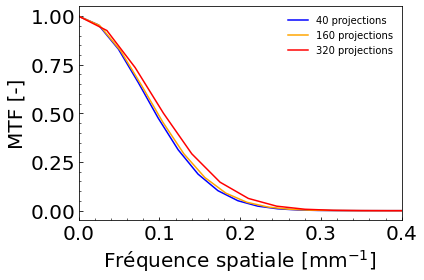

In [87]:
(freq_40, mtf_40) = analyze_edge('partie 5/3d_040_025_milieu.csv', 0.25)
(freq_160, mtf_160) = analyze_edge('partie 5/3d_160_025_milieu.csv', 0.25)
(freq_320, mtf_320) = analyze_edge('partie 5/3d_320_025_milieu.csv', 0.25)

plt.figure()
plt.plot(freq_40, mtf_40, color="blue", label='40 projections')
plt.plot(freq_160, mtf_160, color="orange", label='160 projections')
plt.plot(freq_320, mtf_320, color="red", label='320 projections')
plt.xlim(0, 0.4)
plt.ylabel("MTF [-]", fontsize=20)
plt.xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=20)
plt.legend(frameon=False) 
plt.tick_params(axis='both', which='both', direction='in', labelsize=20)
plt.minorticks_on()
plt.tight_layout()
plt.show()

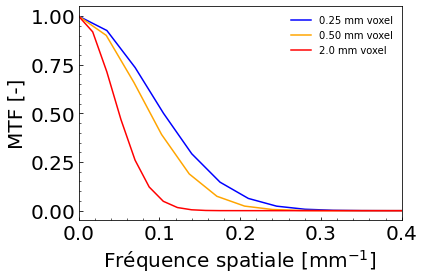

In [88]:
(freq_025, mtf_025) = analyze_edge('partie 5/3d_320_025_milieu.csv', 0.25)
(freq_050, mtf_050) = analyze_edge('partie 5/3d_320_050_milieu.csv', 0.50)
(freq_200, mtf_200) = analyze_edge('partie 5/3d_320_200_milieu.csv', 2.0)

plt.figure()
plt.plot(freq_025, mtf_025, color="blue", label='0.25 mm voxel')
plt.plot(freq_050, mtf_050, color="orange", label='0.50 mm voxel')
plt.plot(freq_200, mtf_200, color="red", label='2.0 mm voxel')
plt.xlim(0, 0.4)
plt.ylabel("MTF [-]", fontsize=20)
plt.xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=20)
plt.legend(frameon=False) 
plt.tick_params(axis='both', which='both', direction='in', labelsize=20)
plt.minorticks_on()
plt.tight_layout()
plt.show()

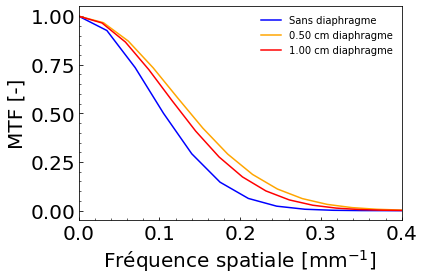

In [89]:
(freq_sans, mtf_sans) = analyze_edge('partie 5/3d_320_025_milieu.csv', 0.25)
(freq_dia_050, mtf_dia_050) = analyze_edge('partie 5/3d_320_025_dia050.csv', 0.25)
(freq_dia_100, mtf_dia_100) = analyze_edge('partie 5/3d_320_025_dia100.csv', 0.25)
#(freq_dia_150, mtf_dia_150) = analyze_edge('partie 5/3d_320_025_dia150.csv', 0.25)

plt.figure()
plt.plot(freq_sans, mtf_sans, color="blue", label='Sans diaphragme')
plt.plot(freq_dia_050, mtf_dia_050, color="orange", label='0.50 cm diaphragme')
plt.plot(freq_dia_100, mtf_dia_100, color="red", label='1.00 cm diaphragme')
#plt.plot(freq_dia_150, mtf_dia_150, label='1.50 cm diaphragme')
plt.xlim(0, 0.4)
plt.ylabel("MTF [-]", fontsize=20)
plt.xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=20)
plt.legend(frameon=False) 
plt.tick_params(axis='both', which='both', direction='in', labelsize=20)
plt.minorticks_on()
plt.tight_layout()
plt.show()

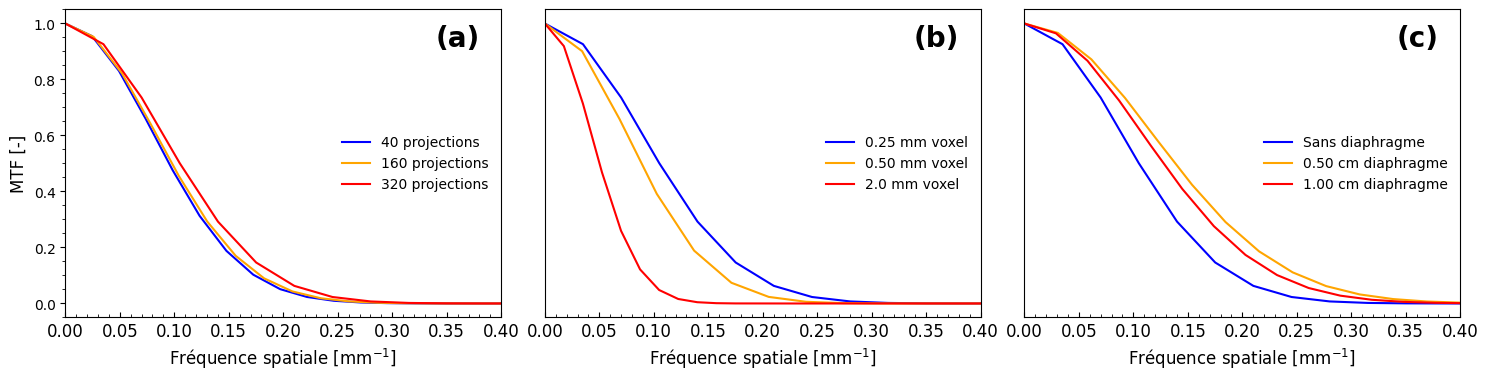

In [27]:
# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

# Plot 1
(freq_40, mtf_40) = analyze_edge('partie 5/3d_040_025_milieu.csv', 0.25)
(freq_160, mtf_160) = analyze_edge('partie 5/3d_160_025_milieu.csv', 0.25)
(freq_320, mtf_320) = analyze_edge('partie 5/3d_320_025_milieu.csv', 0.25)

axs[0].plot(freq_40, mtf_40, color="blue", label='40 projections')
axs[0].plot(freq_160, mtf_160, color="orange", label='160 projections')
axs[0].plot(freq_320, mtf_320, color="red", label='320 projections')
axs[0].set_xlim(0, 0.4)
axs[0].set_ylabel("MTF [-]", fontsize=12)
axs[0].set_xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=12)
axs[0].legend(frameon=False, loc='center right')
axs[0].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False)
axs[0].tick_params(axis='x', which='both', direction='in', labelsize=12)
axs[0].text(0.95, 0.95, '(a)', horizontalalignment='right', verticalalignment='top', transform=axs[0].transAxes, weight='bold', size=20)
axs[0].minorticks_on()

# Plot 2
(freq_025, mtf_025) = analyze_edge('partie 5/3d_320_025_milieu.csv', 0.25)
(freq_050, mtf_050) = analyze_edge('partie 5/3d_320_050_milieu.csv', 0.50)
(freq_200, mtf_200) = analyze_edge('partie 5/3d_320_200_milieu.csv', 2.0)

axs[1].plot(freq_025, mtf_025, color="blue", label='0.25 mm voxel')
axs[1].plot(freq_050, mtf_050, color="orange", label='0.50 mm voxel')
axs[1].plot(freq_200, mtf_200, color="red", label='2.0 mm voxel')
axs[1].set_xlim(0, 0.4)
axs[1].set_xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=12)
axs[1].legend(frameon=False, loc='center right')
axs[1].tick_params(axis='both', which='both', direction='in', labelsize=12)
axs[1].minorticks_on()
axs[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
axs[1].text(0.95, 0.95, '(b)', horizontalalignment='right', verticalalignment='top', transform=axs[1].transAxes, weight='bold', size=20)

# Plot 3
(freq_sans, mtf_sans) = analyze_edge('partie 5/3d_320_025_milieu.csv', 0.25)
(freq_dia_050, mtf_dia_050) = analyze_edge('partie 5/3d_320_025_dia050.csv', 0.25)
(freq_dia_100, mtf_dia_100) = analyze_edge('partie 5/3d_320_025_dia100.csv', 0.25)

axs[2].plot(freq_sans, mtf_sans, color="blue", label='Sans diaphragme')
axs[2].plot(freq_dia_050, mtf_dia_050, color="orange", label='0.50 cm diaphragme')
axs[2].plot(freq_dia_100, mtf_dia_100, color="red", label='1.00 cm diaphragme')
axs[2].set_xlim(0, 0.4)
axs[2].set_xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=12)
axs[2].legend(frameon=False, loc='center right')
axs[2].tick_params(axis='both', which='both', direction='in', labelsize=12)
axs[2].minorticks_on()
axs[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
axs[2].text(0.95, 0.95, '(c)', horizontalalignment='right', verticalalignment='top', transform=axs[2].transAxes, weight='bold', size=20)

# Adjust layout
plt.subplots_adjust(wspace=0.1)

# Show plot
plt.show()
